<a href="https://colab.research.google.com/github/nedaa135/paython/blob/main/GA%20algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

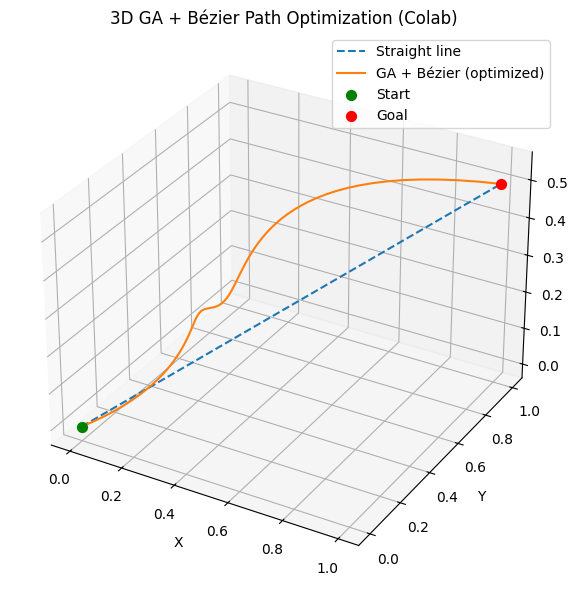

Best fitness: 0.6140993664744101
Number of GA generations: 61


In [6]:
!pip -q install pygad bezier

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pygad
import numpy as np
from math import sqrt
from copy import deepcopy
import bezier
import random

# --------------------------------------------
# Euclidean distance (3D)
# --------------------------------------------
def euclidean_distance(point1, point2):
    dx = point1[0] - point2[0]
    dy = point1[1] - point2[1]
    dz = point1[2] - point2[2]
    return sqrt(dx*dx + dy*dy + dz*dz)

# --------------------------------------------
# Fitness function: shorter Bézier curve = better
# solution is a flat array of intermediate 3D points
# e.g., [x1,y1,z1, x2,y2,z2, ...]
# --------------------------------------------
def calculate_fitness(start_point, goal_point, solution):
    # Decode solution into intermediate points
    n_points = len(solution) // 3
    points = [start_point.tolist()]
    for i in range(n_points):
        x = solution[3*i + 0]
        y = solution[3*i + 1]
        z = solution[3*i + 2]
        points.append([x, y, z])
    points.append(goal_point.tolist())

    points = np.array(points, dtype=float)  # shape (N,3)

    # Nodes for Bezier: shape (dim, n_nodes)
    nodes = points.T  # (3, N)


    if nodes.shape[1] > 6:
        idx = np.linspace(0, nodes.shape[1]-1, 6).astype(int)
        nodes = nodes[:, idx]

    curve = bezier.Curve.from_nodes(nodes)
    length = curve.length

    # We want to minimize length → GA maximizes fitness, so invert
    fitness = 1.0 / (length + 1e-6)
    return fitness

# --------------------------------------------
# GA function
# --------------------------------------------
def ga(start_point, goal_point,
       num_generations=50,
       population_size=100,
       n_intermediate_points=3,
       workspace_min=(-1.0, -1.0, -1.0),
       workspace_max=( 1.5,  1.5,  1.5)):
    """
    start_point, goal_point: numpy arrays of shape (3,)
    Returns: list of 3D points along the smoothed Bézier path.
    """

    start_point = np.array(start_point, dtype=float)
    goal_point  = np.array(goal_point, dtype=float)

    num_genes = n_intermediate_points * 3  # each point = (x,y,z)


    min_x, min_y, min_z = workspace_min
    max_x, max_y, max_z = workspace_max

    def fitness_func(ga_instance, solution, solution_idx):

        sol = np.array(solution, dtype=float)
        for i in range(n_intermediate_points):
            sol[3*i + 0] = np.clip(sol[3*i + 0], min_x, max_x)
            sol[3*i + 1] = np.clip(sol[3*i + 1], min_y, max_y)
            sol[3*i + 2] = np.clip(sol[3*i + 2], min_z, max_z)
        return calculate_fitness(start_point, goal_point, sol)

    ga_instance = pygad.GA(
        num_generations=num_generations,
        sol_per_pop=population_size,
        num_genes=num_genes,
        init_range_low=-1.0,
        init_range_high=1.0,
        parent_selection_type="rws",
        num_parents_mating=2,
        fitness_func=fitness_func,
        crossover_type="single_point",
        crossover_probability=0.9,
        mutation_type="random",
        mutation_probability=0.1
    )

    ga_instance.run()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    # Decode best solution into 3D points
    n_points = len(solution) // 3
    points = [start_point.tolist()]
    for i in range(n_points):
        x = np.clip(solution[3*i + 0], min_x, max_x)
        y = np.clip(solution[3*i + 1], min_y, max_y)
        z = np.clip(solution[3*i + 2], min_z, max_z)
        points.append([x, y, z])
    points.append(goal_point.tolist())

    points = np.array(points, dtype=float)

    # Construct Bezier curve and sample it
    nodes = points.T
    if nodes.shape[1] > 6:
        idx = np.linspace(0, nodes.shape[1]-1, 6).astype(int)
        nodes = nodes[:, idx]

    curve = bezier.Curve.from_nodes(nodes)
    s_vals = np.linspace(0.0, 1.0, 100)
    curve_points = curve.evaluate_multi(s_vals).T  # shape (100,3)


    # we return 3D points along the smooth trajectory.
    path_points = [start_point.tolist()]
    for p in curve_points:
        path_points.append(p.tolist())
    path_points.append(goal_point.tolist())

    return path_points, ga_instance

# --------------------------------------------
# Straight-line interpolation
# --------------------------------------------
def straight(start_point, goal_point, n_steps=30):
    start_point = np.array(start_point, dtype=float)
    goal_point  = np.array(goal_point, dtype=float)
    points = []
    for i in range(n_steps+1):
        t = float(i) / float(n_steps)
        p = (1.0 - t) * start_point + t * goal_point
        points.append(p.tolist())
    return points

# --------------------------------------------
# DEMO: Run GA vs Straight line and plot in 3D
# --------------------------------------------
if __name__ == "__main__":
    # Example start/goal in 3D
    start = np.array([0.0, 0.0, 0.0])
    goal  = np.array([1.0, 1.0, 0.5])

    # GA + Bézier
    ga_path, ga_instance = ga(start, goal,
                              num_generations=60,
                              population_size=80,
                              n_intermediate_points=4,
                              workspace_min=(-0.5, -0.5, -0.5),
                              workspace_max=(1.5, 1.5, 1.0))

    # Straight line
    straight_path = straight(start, goal, n_steps=30)

    ga_arr = np.array(ga_path)
    st_arr = np.array(straight_path)

    # Plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    ax.plot(st_arr[:,0], st_arr[:,1], st_arr[:,2],
            "--", label="Straight line")
    ax.plot(ga_arr[:,0], ga_arr[:,1], ga_arr[:,2],
            "-", label="GA + Bézier (optimized)")

    ax.scatter(start[0], start[1], start[2], c="g", s=50, label="Start")
    ax.scatter(goal[0], goal[1], goal[2], c="r", s=50, label="Goal")

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("3D GA + Bézier Path Optimization (Colab)")
    ax.legend()
    plt.tight_layout()
    plt.show()


    print("Best fitness:", ga_instance.best_solution()[1])
    print("Number of GA generations:", len(ga_instance.best_solutions_fitness))
